In [ ]:
!pip install imageio
!pip install Pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)
print(imageio.__version__)

tensorflow 2.8.2
2.4.1


In [ ]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170508288/170498071 [==============================] - 11s 0us/step


(50000, 32, 32, 3)

In [ ]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [ ]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: -0.9921568627450981
min pixel: -1.007843137254902


In [ ]:
train_x.shape

(50000, 32, 32, 3)

In [ ]:
train_x = train_x.reshape(train_x.shape[0], 32,32, 3).astype('float32')
train_x.shape

(50000, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


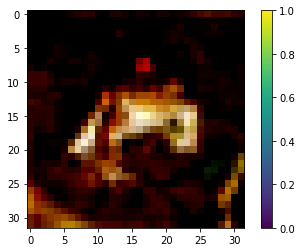

In [ ]:
plt.imshow(train_x[0].reshape(32, 32,3))
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

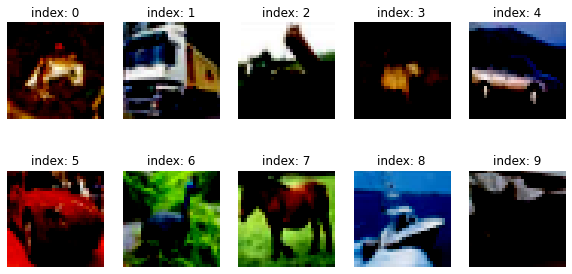

In [ ]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i].reshape(32, 32,3), cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

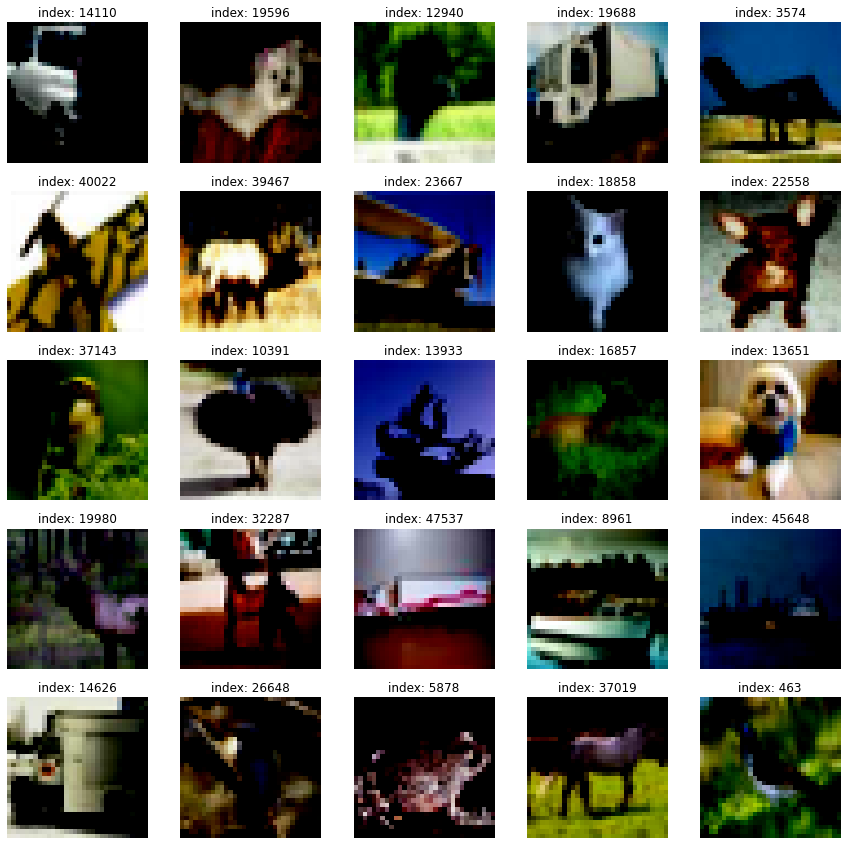

In [ ]:
plt.figure(figsize=(15, 15))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow(train_x[random_index])
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

다행히 이미지는 RGB순서대로 잘 나온다.

In [ ]:
BUFFER_SIZE = 50000
BATCH_SIZE = 250

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Make Generator model

In [ ]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [ ]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        524288    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128)        5

In [ ]:
noise = tf.random.normal([1, 100])

In [ ]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

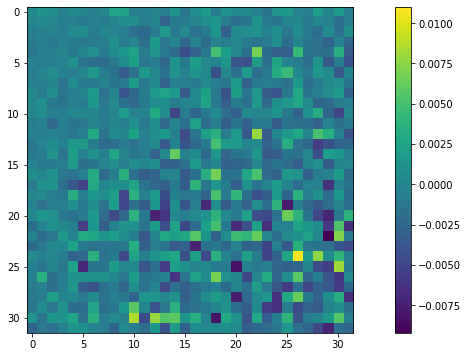

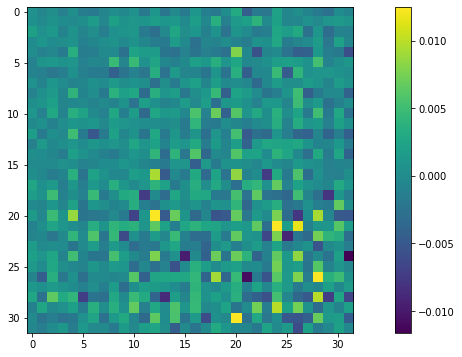

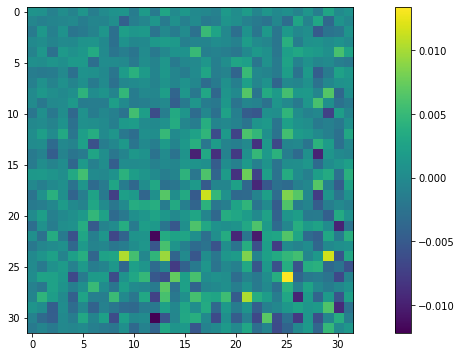

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


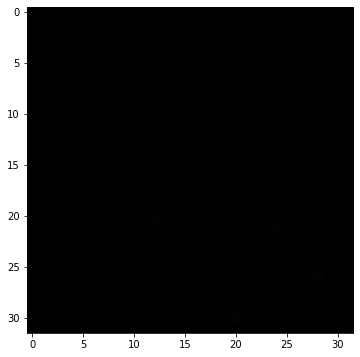

In [ ]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()
plt.imshow(generated_image[0, :, :, 1])
plt.colorbar()
plt.show()
plt.imshow(generated_image[0, :, :, 2])
plt.colorbar()
plt.show()
plt.imshow(generated_image[0, :, :, :])
plt.show()

# make_Discriminator_Model

In [ ]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        3136      
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         131200    
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)             

In [ ]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00032128]], dtype=float32)>

# Loss

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
vector = [[1, 2, 3],
          [4, 5, 6]]

tf.ones_like(vector)

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)>

## Generator_Loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Discriminator_Loss

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

## Discrimiantor_Accuracy

In [ ]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

# 최적화 함수(optimizer)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

# 모델 학습

**tf.function** : Compiles a function into a callable TensorFlow graph

In [ ]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

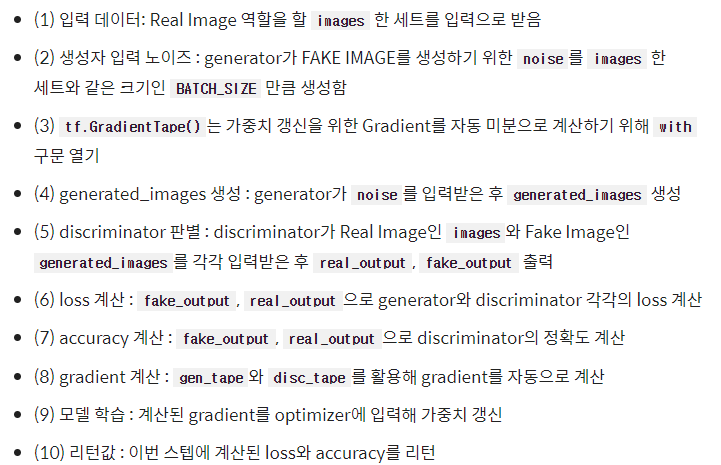

In [ ]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(10, 10))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, :])
        plt.axis('off')
   
    plt.savefig('/content/drive/MyDrive/Colab Notebooks/LMS/dcgan_newimage/CIFAR10/Mk2/sample2/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(epoch, it))

    plt.show()

In [ ]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('/content/drive/MyDrive/Colab Notebooks/LMS/dcgan_newimage/CIFAR10/Mk2/his2/train_history_{:04d}.png'
                    .format(epoch))
    plt.show() 

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/Colab Notebooks/LMS/dcgan_newimage/CIFAR10/Mk2/checkpoint'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [ ]:
save_every = 10
EPOCHS = 500

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

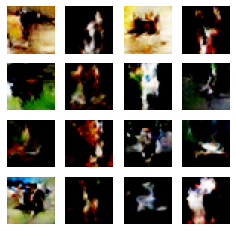

Time for training : 9321 sec


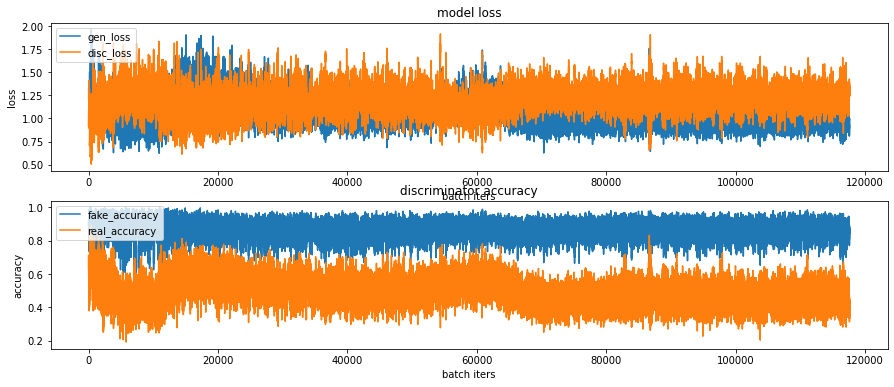

CPU times: user 2h 35min 27s, sys: 4min 8s, total: 2h 39min 35s
Wall time: 2h 35min 27s


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

In [ ]:
anim_file = '/content/drive/MyDrive/Colab Notebooks/LMS/dcgan_newimage/CIFAR10/CIFAR_dcgan.gif'

In [ ]:
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/Colab Notebooks/LMS/dcgan_newimage/CIFAR10/genreated_samples/sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [ ]:
!ls -l /content/drive/MyDrive/Colab\ Notebooks/LMS/dcgan_newimage/CIFAR10/CIFAR_dcgan.gif

-rw------- 1 root root 3453529 Jun 22 00:18 '/content/drive/MyDrive/Colab Notebooks/LMS/dcgan_newimage/CIFAR10/CIFAR_dcgan.gif'


# 결과

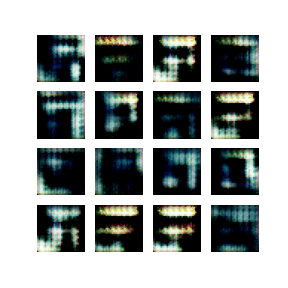

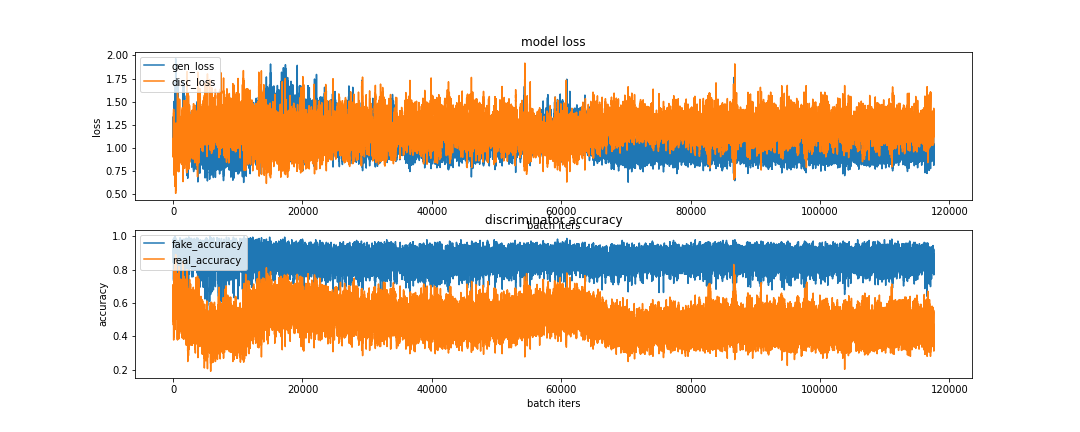

~아 좀더 크게 이미지 만들껄..;~ 

600 epoch으로 학습시킨 최종 결과물은 아직 정교한 무언가가 나오기 전 인듯한 이미지가 나왔다.

batch size를 조절하던, convolution filtre의 사이즈를 바꾸던, 학습 횟수를 늘리던 더 조정 할 여지는 많다.

# MK.2

Genrerator & Discriminator model을 VGG-11모델을 차용하여 재도전

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()

    model.add(layers.Dense(1*1*512, use_bias=False, input_shape=(100,)))


    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())


    model.add(layers.Reshape((1, 1, 512)))


    model.add(layers.Conv2DTranspose(512, kernel_size=(3, 3), strides=(2 , 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(256, kernel_size=(3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())


    model.add(layers.Conv2DTranspose(256, kernel_size=(2, 2), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
       

    model.add(layers.Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())


    model.add(layers.Conv2DTranspose(64, kernel_size=(3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())


    model.add(layers.Conv2DTranspose(3, kernel_size=(3, 3), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [ ]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               51200     
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 2, 2, 512)        2359296   
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 2, 2, 512)        2

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (3, 3),strides=(2,2), input_shape=[32,32,3], padding='same'))
    model.add(layers.BatchNormalization(momentum=0.99))
    model.add(layers.LeakyReLU())
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides = (2, 2),padding='same'))

    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(layers.BatchNormalization(momentum=0.99))
    model.add(layers.LeakyReLU())
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides = (2, 2),padding='same'))

    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.BatchNormalization(momentum=0.99))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.BatchNormalization(momentum=0.99))
    model.add(layers.LeakyReLU())
    
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides = (2, 2),padding='same'))

    model.add(layers.Conv2D(512, (3, 3), padding='same'))
    model.add(layers.BatchNormalization(momentum=0.99)) 
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(512, (3, 3), padding='same'))
    model.add(layers.BatchNormalization(momentum=0.99))
    model.add(layers.LeakyReLU())

    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides = (2, 2),padding='same'))


    model.add(layers.Conv2D(512, (3, 3), padding='same'))
    model.add(layers.BatchNormalization(momentum=0.99))    
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(512, (3, 3), padding='same'))
    model.add(layers.BatchNormalization(momentum=0.99))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Flatten()) 

    model.add(layers.Dense(1))
    return model

In [ ]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 16, 16, 64)        1792      
                                                                 
 batch_normalization_14 (Bat  (None, 16, 16, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 batch_normalization_15 (Bat  (None, 8, 8, 128)       

In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

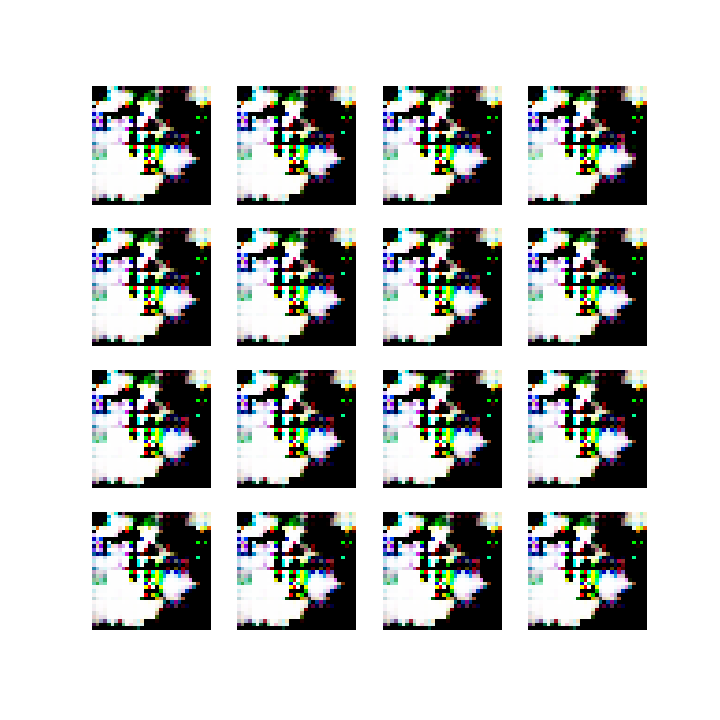

학습 시간이 모자라 도중에 종료하였다.

In [ ]:
anim_file = '/content/drive/MyDrive/Colab Notebooks/LMS/dcgan_newimage/CIFAR10/Mk2/CIFAR_MK2_dcgan.gif'

In [ ]:
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/Colab Notebooks/LMS/dcgan_newimage/CIFAR10/Mk2/sample/sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

# MK.2 학습  결과 

### LOSS & ACCURACY


In [ ]:
anim_file = '/content/drive/MyDrive/Colab Notebooks/LMS/dcgan_newimage/CIFAR10/CIFAR_dcgan.gif'

In [ ]:
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/Colab Notebooks/LMS/dcgan_newimage/CIFAR10/genreated_samples/sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

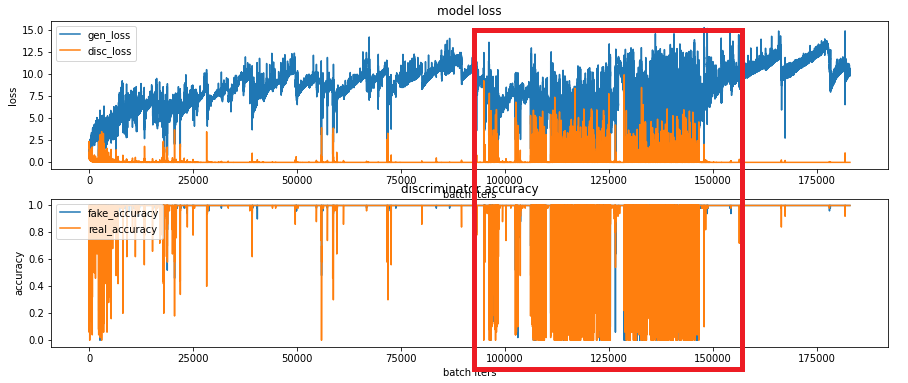

### Sample.gif

gif 파일이 너무 커서 링크로 대체

https://drive.google.com/file/d/1GC2NgG5fsWh4ficT4F30VuHWvscTGoeN/view?usp=sharing

# 회고

기본 모델의 경우 fake acc가 600epoch을 학습했음에도 거의 줄어들지 않았다.

이동평균선을 통해 추가 line을 그렸다면 미묘한 변화를 그릴 수 있었겠지만 

학습당시 생각나지 않아 아쉬웠다.

다음으로 조금더 deep한 Mk.2 모델을 만들어 학습을 시켜보았을 때

초반에는 discriminator가 가짜를 잘 잡아냈었으나 iteration이 계속되면서

generator의 loss가 큰 폭으로 채터링 하는 현상이 발생했고, 이에 따라 discriminator의 정확도가 0~100%까지의 큰 폭으로 채터링 되었다.

이 때 sample 이미지가 아주 다이나믹 하게 변화하는 모습을 보였다. 

그러나 다시 discriminator의 정확도가 안정됨에 따라 generator의 로스가 증가하며, genertor를 통해 생성된 이미지도 거의 변화하지 않는 모습을 보였다.

이에 따라 내린 결론은 generator의 성능에 비해 discriminator의 성능이 너무 좋았을 수 있다는 생각이 들었고,

이에 따라 generator가 만들어내는 이미지들은 훈련에 사용되기 위한 데이터 셋에 가까운 모습이 아닌 discriminator의 판별을 피하기 위한 이미지들로 생성되어 원하는 결과가 나오지 않은 것 같다는 생각이 들었다.

또한 이번 generator모델과 discriminator모델은 VGG 11모델을 참조해서 만들었으나 generator model은 만들기가 유독 어려웠고, 원하던 아키텍쳐도 나오지 않았다.

이번 노드를 하며 레이어의 출력과 파라미터를  조절하는 능력이 부족함을 깨달았다.